In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('C:/Users/nerpa/Dropbox (Princeton)/Research/discrete_sr/code/SPIDER_discrete')

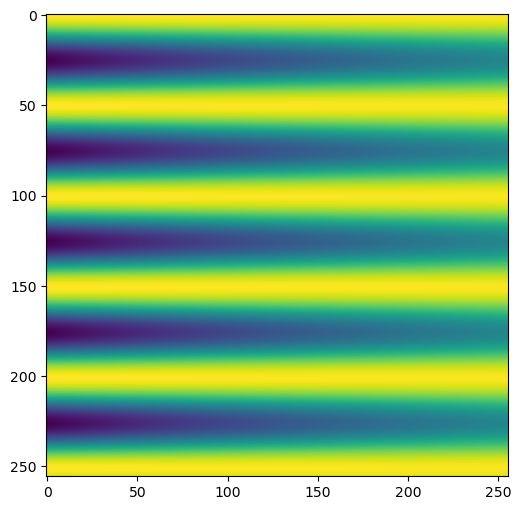

In [2]:
import numpy as np

from utils import save, load
from library import *
from continuous.process_library_terms import *
import matplotlib.pyplot as plt

#import h5py
#with h5py.File('NSE2D/uvp-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/uvp2-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/tgv-0.001.mat', 'r') as mat:
    #P = np.array(mat['P'])
    #U = np.array(mat['U'])
    #V = np.array(mat['V'])
    
#import netCDF4 as nc
#fn = '/path/to/file.nc4'
#ds = nc.Dataset(fn)

# for some reason, we need to fix the order of the axes
#P = np.transpose(P, (1, 2, 0))
#U = np.transpose(U, (1, 2, 0))
#V = np.transpose(V, (1, 2, 0))

Lx = 4; Ly = 4; Lt = 1;
#Nx = 512; Ny = Nx; Nt = 1000; # normal resolution
#Nx = 256; Ny = Nx; Nt = 1000; # half resolution
Nx = 256; Ny = Nx; Nt = Nx # analytical
dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;

# don't use MATLAB data
x = np.arange(0, 4, dx); y = np.arange(0, 4, dy); t = np.arange(0, 1, dt)
xg, yg = np.meshgrid(x, y)
U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.32*t))
V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.32*t))
P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-0.64*t))

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(P[:, 128, :])

In [3]:
%%prun # profiling

uobs = Observable(string='u', rank=1)
pobs = Observable(string='p', rank=0)
u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)
observables = [uobs, pobs]
data_dict = {'p': P, 'u': u}

# fix random seed
np.random.seed(1)

world_size = np.array(U.shape)
pad = 0

# fix random seed
np.random.seed(1)

dxs = [dx, dy, dt]
dom_width = 64
dom_time = 50

# initial setup of dataset
corr_L = 5
corr_T = 5
srd = SRDataset(world_size=world_size, data_dict=data_dict, observables=observables, dxs=dxs)

# initialize libraries, domains, and weights
srd.make_libraries(max_complexity=4, max_observables=3)

dom_width = 80
dom_time = 50 #previously 20 (without interpolation)
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=pad)
srd.make_weights(m=12, qmax=1)
srd.set_LT_scale(L=np.sqrt(dx*dy), T=dt) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

         1141400 function calls (1135369 primitive calls) in 3.156 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      208    0.998    0.005    0.999    0.005 z3core.py:4234(Z3_solver_check_assumptions)
      547    0.789    0.001    0.791    0.001 z3core.py:4124(Z3_solver_assert)
       89    0.199    0.002    0.199    0.002 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.169    0.085    0.368    0.184 _methods.py:135(_var)
    99184    0.095    0.000    0.105    0.000 z3core.py:1551(Check)
       93    0.091    0.001    0.092    0.001 z3core.py:4100(Z3_solver_dec_ref)
    44638    0.075    0.000    0.132    0.000 z3core.py:2823(Z3_sort_to_ast)
        1    0.069    0.069    3.156    3.156 <string>:1(<module>)
        2    0.043    0.022    0.411    0.206 _methods.py:204(_std)
    19084    0.034    0.000    0.127    0.000 z3.py:350(__del__)
    19241    0.034    0.000    0.159    0.000 z3.py:345(__init__)
    1

In [4]:
from commons.sparse_reg_bf import *
from commons.identify_models import *
import copy

libs = srd.libs

# for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
scaler0 = Scaler(sub_inds=None, char_sizes=libs[0].col_weights, row_norms=None)
init0 = Initializer(method='combinatorial', start_k=2)
#init0 = Initializer(method='power', start_k=10)
#res0 = Residual(residual_type='fixed_column', anchor_col=0)
res0 = Residual(residual_type='dominant_balance')

iter0 = ModelIterator(max_k=10, backward_forward=True, brute_force=True) # test also boolean toggles
thres0 = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)
#thres0 = Threshold(threshold_type='information', ic=AIC)
#thres0 = Threshold(threshold_type='jump', gamma=1.5, n_terms=3)

opts = {'scaler': scaler0, 'initializer': init0, 'residual': res0,
        'model_iterator': iter0, 'threshold': thres0}
opts['verbose'] = False
opts1 = copy.deepcopy(opts) # need to be careful to deep copy for the stateful ModelIterator
opts['inhomog'] = False
opts['inhomog_col'] = None
#opts['verbose'] = False
sub_inds1 = list(range(len(libs[1].terms)))
opts1['scaler'] = Scaler(sub_inds=sub_inds1, char_sizes=libs[1].col_weights)
opts1['residual'] = Residual(residual_type='fixed_column', anchor_col=13)
opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)
    
opts['verbose']=False
opts1['verbose']=False

# note that interleave_identify doesn't work with inhomog or fixed-column residual
opts1['inhomog'] = False
opts1['inhomog_col'] = None
opts1['residual'] = copy.deepcopy(opts['residual'])
opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)

eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2, experimental=True)

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed